# Unterpunkt 3: The time-dependent Schrödinger equation
# in one dimension with Crank-Nicolson

In [17]:
import numpy as np
import matplotlib.pyplot as plt

### Unterpunkt a: Schrödinger lösen

In [18]:

def schroedinger_cn(Nx, dx, Nt, dt, psi0, V):
    # Schritte nach Angabe
    # Schritt 1: Randbedingungen
    psi = np.zeros((Nt+1, Nx), dtype=complex)
    psi[0] = psi0
    
    # Schritt 2: a_k berechnen
    a = np.zeros(Nx, dtype=complex)
    a[1] = 2 * (1 + dx*dx*V[1] - 1j*2*dx*dx/dt)

    for k in range(2, Nx-1):
        a[k] = 2 * (1 + dx*dx*V[k] - 1j*2*dx*dx/dt) - 1/a[k-1]

    # Schritt 3–7: Zeitentwicklung
    for n in range(Nt):
        # Schritt 4: Ω_k^n
        Omega = np.zeros(Nx, dtype=complex)
        for k in range(1, Nx-1):
            Omega[k] = (
                -psi[n, k-1]
                + 2*(1j*2*dx*dx/dt + 1 + dx*dx*V[k]) * psi[n, k]
                - psi[n, k+1]
            )

        # Schritt 5: b_k^n
        b = np.zeros(Nx, dtype=complex)
        b[1] = Omega[1]
        for k in range(2, Nx-1):
            b[k] = b[k-1]/a[k-1] + Omega[k]

        # Schritt 6: Rückwärtssubstitution
        psi[n+1, 0] = 0
        psi[n+1, -1] = 0
        for k in range(Nx-2, 0, -1):
            psi[n+1, k] = (psi[n+1, k+1] - b[k]) / a[k]

    return psi


### Unterpunkt b: Gauss Packet

In [ ]:

def gauss_packet(Nx, dx, sigma, x0, q):
    
    x = np.arange(Nx) * dx
    psi0 = np.exp(-((x - x0)**2) / (2*sigma**2)) * np.exp(1j * q * x)
    psi0[0] = 0
    psi0[-1] = 0
    psi0 /= np.sqrt(np.sum(np.abs(psi0)**2) * dx) # Normierung sonst is propability nicht conserved
    return psi0


dx = 0.01
Nx = 2000      
dt = 0.001
Nt = 2000     


sigma = 0.5
x0    = 5.0
q     = 10.0

V = np.zeros(Nx)

psi0 = gauss_packet(Nx, dx, sigma, x0, q)
psi = schroedinger_cn(Nx, dx, Nt, dt, psi0, V)


## Verification von den Sachen
x = np.arange(Nx) * dx
dx = x[1] - x[0]
t  = np.arange(psi.shape[0]) * dt
rho = np.abs(psi)**2

# x_max(t) + v_fit
kmax = rho.argmax(axis=1)
xmax = x[kmax]
v = np.polyfit(t, xmax, 1)[0]  # slope

# width d(t) = sqrt(<x^2> - <x>^2)
P  = rho.sum(axis=1) * dx
x1 = (rho * x).sum(axis=1) * dx / P
x2 = (rho * x**2).sum(axis=1) * dx / P
d  = np.sqrt(x2 - x1**2)

print(d)
print(v) 
print(psi.shape)


[ 0.35355339  0.35359449  0.35371777 ... 58.58350702 58.5585322
 58.53353423]
-0.3121042280110044
(5000,)


### Unterpunkt c: Plot

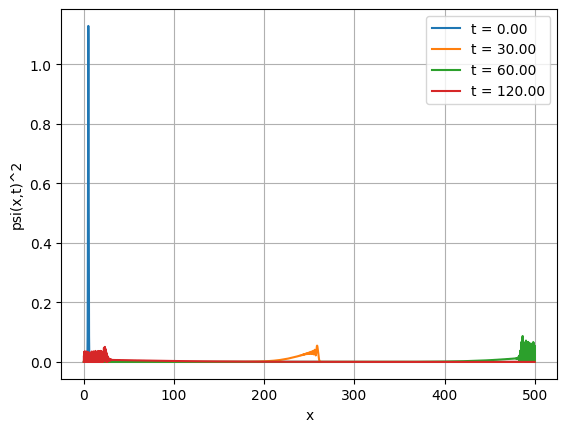

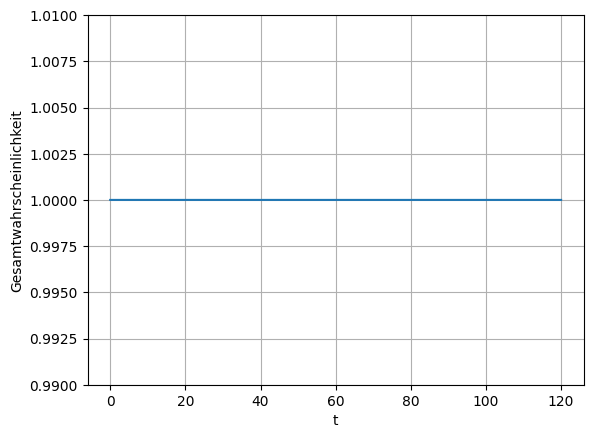

In [20]:

# Raum- und Zeitgitter
x = np.arange(Nx) * dx
t = np.arange(Nt+1) * dt

# Wahrscheinlichkeitsdichte
rho = np.abs(psi)**2

#Plot 1: |psi(x,t)|^2 für vier Snapshots
plt.figure()
for n in [0, Nt//4, Nt//2, Nt]: #Snapshots t=0, t=0.5, t=1.0, t=2.0
    plt.plot(x, rho[n], label=f"t = {t[n]:.2f}")
plt.xlabel("x")
plt.ylabel("psi(x,t)^2")
plt.legend()
plt.grid(True)
plt.show()

#Plot 2: Gesamtwahrscheinlichkeit
norm = np.sum(rho, axis=1) * dx

plt.figure()
plt.plot(t, norm)
plt.xlabel("t")
plt.ylabel("Gesamtwahrscheinlichkeit")
plt.ylim(0.99, 1.01)   
plt.grid(True)
plt.show()





### Unterpunkt d: Potentiale

In [ ]:

sigma = 20.0
q = 2.0
x0 = 0.0

dx = 0.1
Nx = 5000     
dt = 0.01
Nt = 12000     

x = np.arange(Nx) * dx


V0_list = [1.5, 2.0, 2.5]
a = 100.0
b = 200.0
dbar = 10.0

psi0 = gauss_packet(Nx, dx, sigma, x0, q)


def make_V1(V0):
    return V0 * (
        np.heaviside(x - a, 0.0)- np.heaviside(x - (a + dbar), 0.0)
    )


def make_V2(V0):
    return make_V1(V0) + V0 * (
        np.heaviside(x - b, 0.0)- np.heaviside(x - (b + dbar), 0.0)
    )


psi_V1 = {}   
psi_V2 = {}

for V0 in V0_list:
    V1 = make_V1(V0)
    V2 = make_V2(V0)

    psi_V1[V0] = schroedinger_cn(Nx, dx, Nt, dt, psi0, V1)
    psi_V2[V0] = schroedinger_cn(Nx, dx, Nt, dt, psi0, V2)


### Unteerpunkt e: Plots zu Potentialen

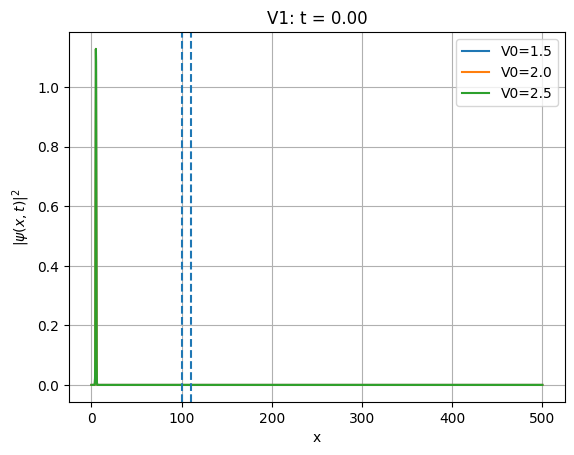

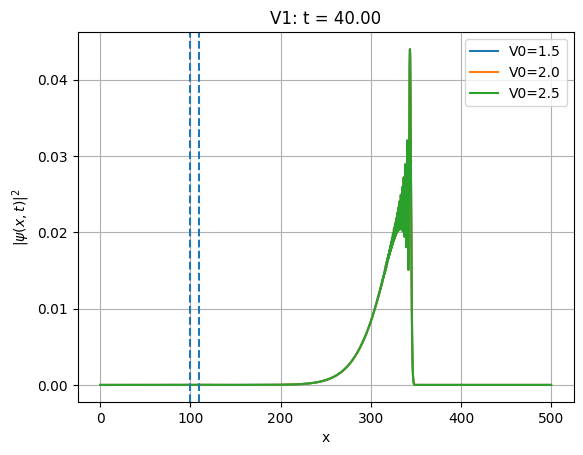

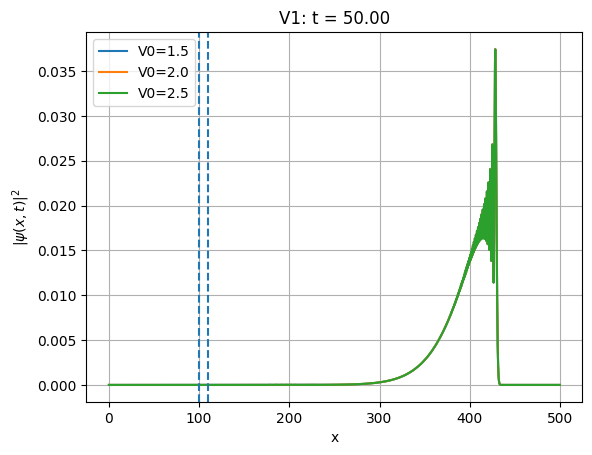

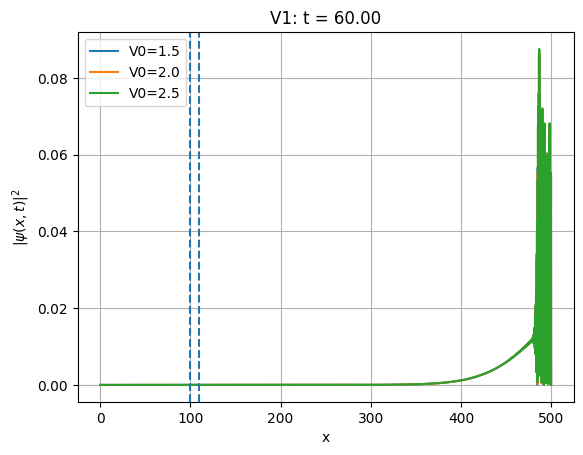

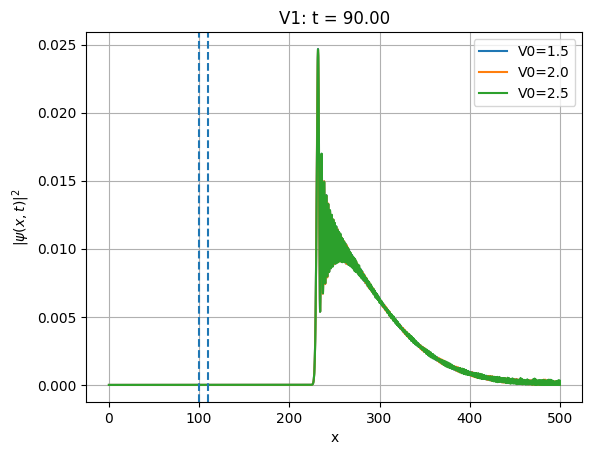

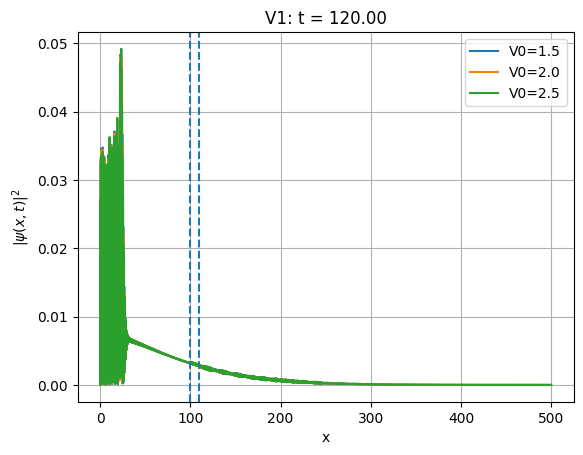

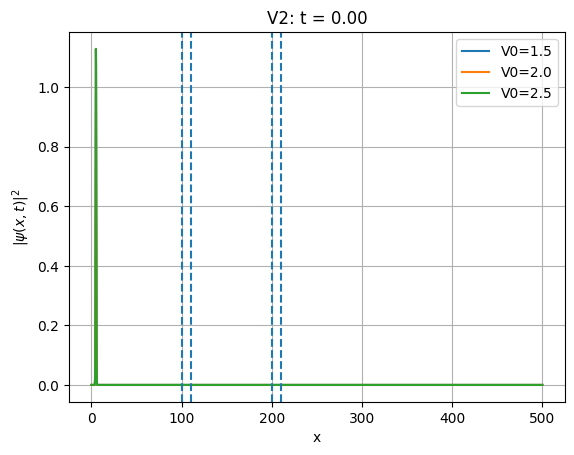

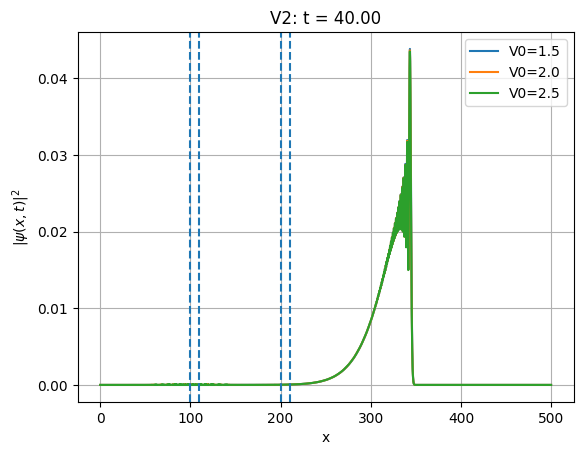

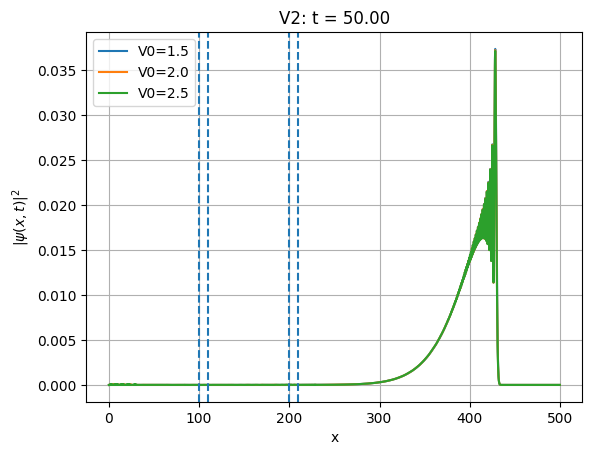

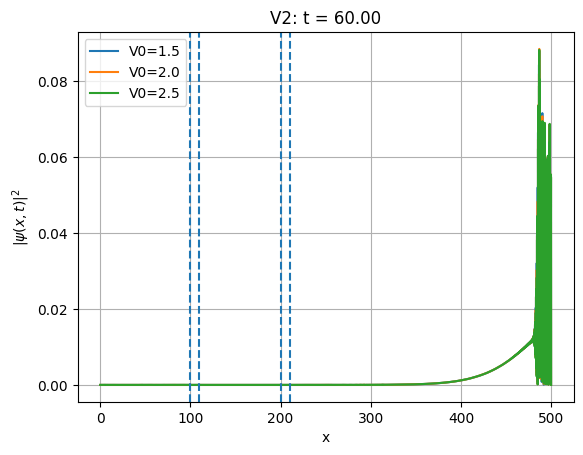

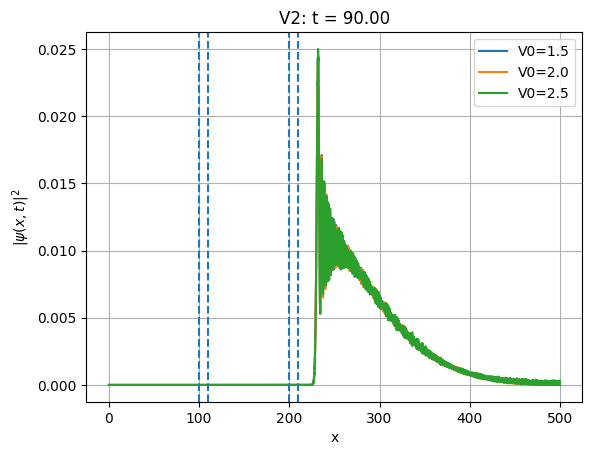

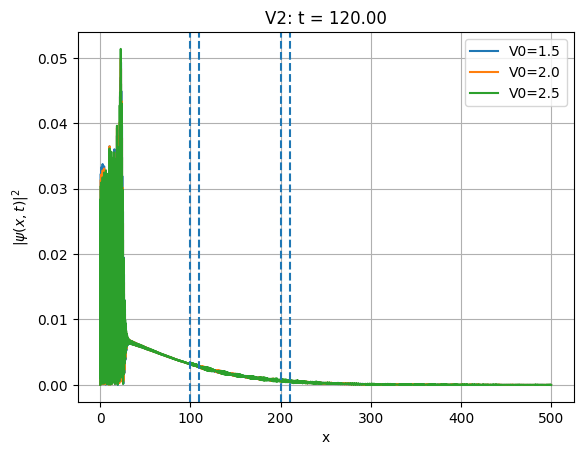

In [ ]:

# snapshot times 
times = [0, 40, 60, 90, 120]
idx_list = [int(tt / dt) for tt in times]

def plot_snapshots(psi_dict, title, idx_list):
    for idx in idx_list:
        plt.figure()
        for V0 in V0_list:
            plt.plot(x, np.abs(psi_dict[V0][idx])**2, label=f"V0={V0}")
        plt.axvline(a, linestyle="--") 
        plt.axvline(a + dbar, linestyle="--")
        if title == "V2":
            plt.axvline(b, linestyle="--") 
            plt.axvline(b + dbar, linestyle="--")
        plt.xlabel("x")
        plt.ylabel("psi(x,t)^2")
        plt.title(f"{title}: t = {idx*dt:.2f}")
        plt.grid(True) 
        plt.legend() 
        plt.show()

# --- plots for 3(e) ---
plot_snapshots(psi_V1, "V1", idx_list)
plot_snapshots(psi_V2, "V2", idx_list)
